# Convolutional Neural Networks For Enhancer Activity Prediction
Adam Klie
09/23/2021

Notebook to train preliminary Convolutional Neural Network (CNN) classifiers for predicting enhancer activity

In [1]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading webpages
from IPython.display import IFrame

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

In [3]:
# Check for GPU
import torch
from torch.utils.data import TensorDataset, DataLoader

print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))

Using a GPU? False


/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Define parameters of the notebook

In [4]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "ohe-seq"  # What features to use to train the model
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
TRAIN = False
SUBSET = False
HYPERPARAM = "baseline_plus"
ARCHITECTURE = "EUGENE2"

# Load data

In [7]:
X = np.load('../data/{0}/{1}/X_{2}_{3}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES, PREPROCESS))
y = np.loadtxt('../data/{0}/y_binary_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), delimiter=' ', dtype=int)
X[0, :4], y[0], X.shape, y.shape

(array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]]),
 1,
 (302936, 66, 4),
 (302936,))

# Train and test a CNN classifier

## **Train/test split**

In [8]:
X_train, X_test, y_train, y_test = project_utils.split_train_test(X, y, split=0.9, subset=SUBSET)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272642, 66, 4), (30294, 66, 4), (272642,), (30294,))

In [9]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

In [10]:
# need to fix this in the EDA
X_train = np.transpose(X_train, axes=(0, 2, 1))
X_test = np.transpose(X_test, axes=(0, 2, 1))

## **CNN training**

#### <u> **Initialize model** </u> 

In [13]:
# Instantiate model and move to gpu if available
from EUGENE_2 import EUGENE
eugene = EUGENE()
eugene.apply(project_utils.init_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on :", device)
eugene.to(device)

Executing the model on : cuda


EUGENE(
  (Conv1): Conv1d(4, 32, kernel_size=(8,), stride=(1,))
  (Conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (Batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Maxpool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (Drop1): Dropout(p=0.5, inplace=False)
  (Linear1): Linear(in_features=1728, out_features=1, bias=True)
)

In [14]:
# Grab some seqs and outputs to test out on
indexes = np.random.choice(len(X_train), size=5)
random_seqs = torch.from_numpy(X_train[indexes, :, :]).float().to(device)
outputs = eugene(random_seqs).squeeze(dim=1)
random_labels = torch.from_numpy(y[indexes]).to(device)
print(outputs, random_labels, project_utils.accuracy(outputs, random_labels)/len(outputs))

tensor([-0.4299,  0.4744,  1.4885, -0.0621, -0.5840], device='cuda:0',
       grad_fn=<SqueezeBackward1>) tensor([0, 0, 1, 0, 0], device='cuda:0') 0.8


#### <u> **Dataloading** </u> 

In [15]:
# Build Datasets objects from arrays
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [16]:
# Build Loaders from the Datasets
train_loader = DataLoader(train_dataset, batch_size=256)
val_loader = DataLoader(val_dataset, batch_size=256)

In [17]:
# Check dims of loaders for correctness
print("Dimensions of training set: {} x {}".format(len(train_loader.dataset), train_loader.dataset[0][0].shape))
print("Dimensions of validation set: {} x {}".format(len(val_loader.dataset), val_loader.dataset[0][0].shape))

Dimensions of training set: 272642 x torch.Size([4, 66])
Dimensions of validation set: 30294 x torch.Size([4, 66])


#### <u> **Training** </u> 

In [18]:
from livelossplot import PlotLosses

In [19]:
# Current livelossplot compatible training script
def train_model(model, criterion, optimizer, num_epoch):
    liveloss = PlotLosses()
    loss_history, acc_history = {}, {}
    for epoch in range(num_epoch):
        logs = {}
        for phase in ['validation', 'train']:
            if phase == 'train':
                if epoch < 150:
                    model.train()
                else:
                    model.eval()
            else:
                model.eval()
            
            running_loss = 0.0
            running_acc = 0.0
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                outputs = model(inputs.float())
                targets = targets.unsqueeze(dim=1).to(device)
                loss = criterion(outputs, targets.float())
                if phase == 'train':
                    if epoch < 150:
                        optimizer.zero_grad()
                        loss.backward()                
                        optimizer.step()            
                
                running_loss += loss.item()
                running_acc += project_utils.accuracy(outputs, targets)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_acc / len(dataloaders[phase].dataset)
                
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss
            logs[prefix + 'acc'] = epoch_acc
            
            loss_history.setdefault(phase, []).append(epoch_loss)
            acc_history.setdefault(phase, []).append(epoch_acc)
            
        liveloss.update(logs)
        liveloss.send()
    return loss_history, acc_history, liveloss

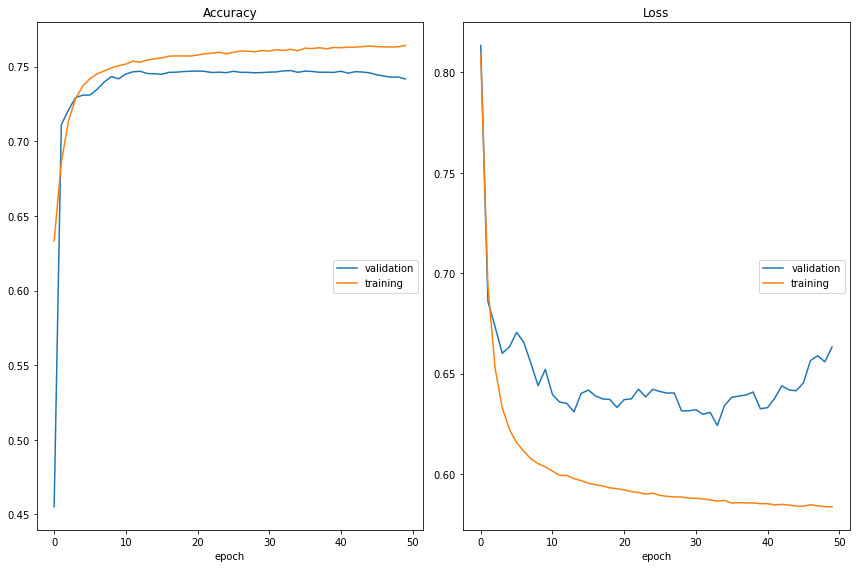

Accuracy
	validation       	 (min:    0.455, max:    0.747, cur:    0.742)
	training         	 (min:    0.633, max:    0.764, cur:    0.764)
Loss
	validation       	 (min:    0.624, max:    0.813, cur:    0.663)
	training         	 (min:    0.584, max:    0.809, cur:    0.584)


In [20]:
### Train the model
dataloaders = {"train": train_loader, "validation": val_loader}
optimizer = torch.optim.Adam(eugene.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor(1.3))
loss_history, acc_history, _ = train_model(eugene, criterion, optimizer, 50)

#### <u> **Save final model** </u> 

In [23]:
torch.save(eugene.state_dict(), "{}_{}_{}-clf_{}.pt".format(PREPROCESS, FEATURES, ARCHITECTURE, HYPERPARAM))

## **CNN testing**

### Load model

In [5]:
from EUGENE_2 import EUGENE
test_eugene = EUGENE()
test_eugene.load_state_dict(torch.load("{}_{}_{}-clf_{}.pt".format(PREPROCESS, FEATURES, ARCHITECTURE, HYPERPARAM), map_location=torch.device('cpu')))
test_eugene.eval()

EUGENE(
  (Conv1): Conv1d(4, 32, kernel_size=(8,), stride=(1,))
  (Conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (Batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Maxpool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (Drop1): Dropout(p=0.5, inplace=False)
  (Linear1): Linear(in_features=1728, out_features=1, bias=True)
)

In [11]:
y_tr_outputs = test_eugene(torch.tensor(X_train).float()).detach()
y_tr_probs = torch.sigmoid(y_tr_outputs).detach().numpy()
y_tr_preds = np.round(y_tr_probs)

In [12]:
y_outputs = test_eugene(torch.tensor(X_test).float()).detach()
y_probs = torch.sigmoid(y_outputs).detach().numpy()
y_preds = np.round(y_probs)

### <u>**Confusion matrices** </u>

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
np.unique(y_tr_preds, return_counts=True), np.unique(y_preds, return_counts=True)

((array([0., 1.], dtype=float32), array([240120,  32522])),
 (array([0., 1.], dtype=float32), array([26665,  3629])))

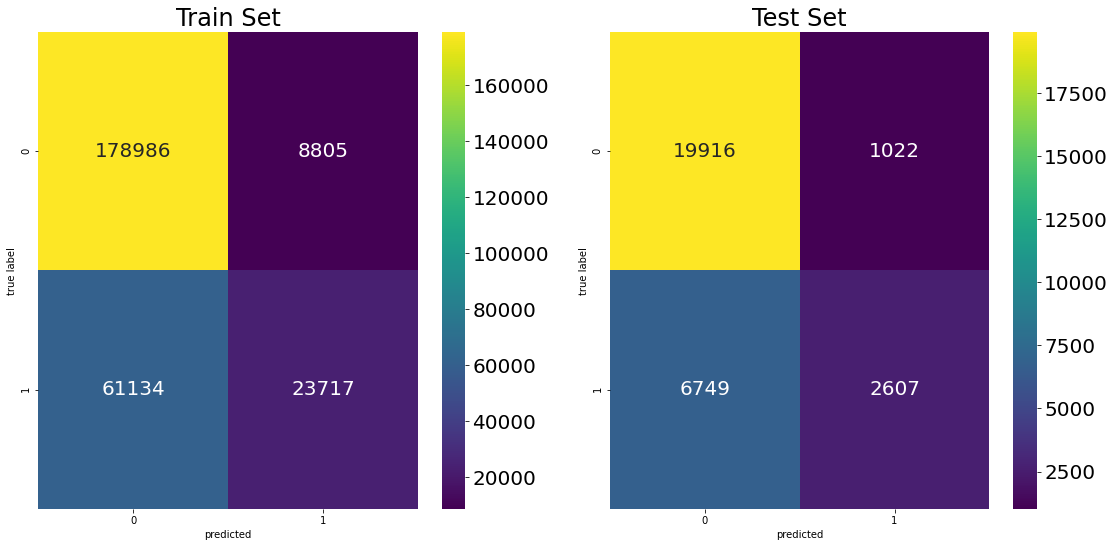

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

rc = {'font.size': 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(y_train, y_tr_preds), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Train Set')

    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Test Set')
    
    plt.tight_layout()

### <u> **Accuracies** </u>

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
train_acc, test_acc = accuracy_score(y_true=y_train, y_pred=y_tr_preds), accuracy_score(y_true=y_test, y_pred=y_preds)

In [18]:
print("Train Acc", "Test Acc", sep='\t')
print("{:.4}\t{:.4f}".format(train_acc, test_acc))

Train Acc	Test Acc
0.7435	0.7435


### <u> **F-scores** </u>

In [19]:
IFrame('https://en.wikipedia.org/wiki/F-score', width=800, height=400)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [21]:
def fbeta_score(pr, rec, beta):
    return (1+(beta**2))*((pr*rec)/(((beta**2)*pr)+rec))

In [22]:
train_prec, test_prec = precision_score(y_true=y_train, y_pred=y_tr_preds), precision_score(y_true=y_test, y_pred=y_preds)

In [23]:
train_recall, test_recall = recall_score(y_true=y_train, y_pred=y_tr_preds), recall_score(y_true=y_test, y_pred=y_preds)

In [24]:
train_f1, test_f1 = f1_score(y_true=y_train, y_pred=y_tr_preds), f1_score(y_true=y_test, y_pred=y_preds)

In [25]:
fbeta_tr_scores = []
fbeta_scores = []
for b in [0.1, 0.5, 1, 2, 10]:
    fbeta_tr_scores.append(fbeta_score(train_prec, train_recall, b))
    fbeta_scores.append(fbeta_score(test_prec, test_recall, b))

In [26]:
print("Metric", "Train", "Test", sep='\t')
print("{:s}\t{:.4f}\t{:.4f}".format("Precision", train_prec, test_prec))
print("{:s}\t{:.4f}\t{:.4f}".format("Recall", train_recall, test_recall))
#print("{:s}\t{:.4f}\t{:.4f}".format("F1-Score", train_f1, test_f1))
for i, b in enumerate([0.1, 0.5, 1, 2, 10]):
    print("F{:s}-Score\t{:.4f}\t{:.4f}".format(str(b), fbeta_tr_scores[i], fbeta_scores[i])) 

Metric	Train	Test
Precision	0.7293	0.7184
Recall	0.2795	0.2786
F0.1-Score	0.7178	0.7073
F0.5-Score	0.5517	0.5460
F1-Score	0.4041	0.4015
F2-Score	0.3188	0.3175
F10-Score	0.2812	0.2803


### <u> **Precision-recall** </u>

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [28]:
precs_tr, recs_tr, threshs_tr = precision_recall_curve(y_true=y_train, probas_pred=y_tr_probs)
avg_prec_tr = average_precision_score(y_true=y_train, y_score=y_tr_probs)

In [29]:
precs, recs, threshs = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
avg_prec = average_precision_score(y_true=y_test, y_score=y_probs)

In [30]:
avg_prec_tr, avg_prec

(0.6020137096160638, 0.5954887119867702)

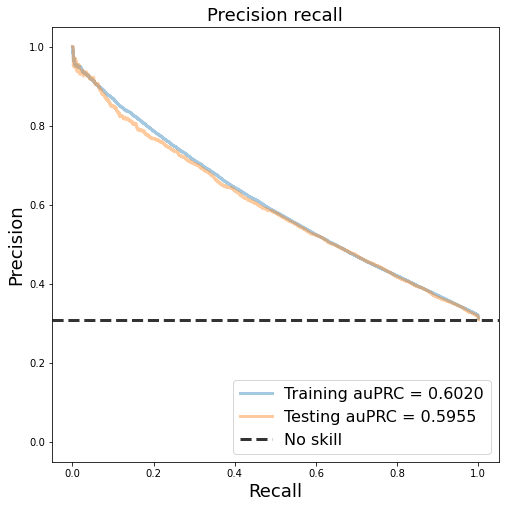

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.step(recs_tr, precs_tr, where='post', lw=3, alpha=0.4, label='Training auPRC = %0.4f' % (avg_prec_tr))
ax.step(recs, precs, where='post', lw=3, alpha=0.4, label='Testing auPRC = %0.4f' % (avg_prec))
ax.axhline(len(y_test[y_test==1])/len(y_test), linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Recall', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
ax.set_title('Precision recall', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

### <u> **Reciever operating characteristic** </u>

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
fprs_tr, tprs_tr, threshs_tr = roc_curve(y_true=y_train, y_score=y_tr_probs)
roc_auc_tr = auc(fprs_tr, tprs_tr)

In [34]:
fprs, tprs, threshs = roc_curve(y_true=y_test, y_score=y_probs)
roc_auc = auc(fprs, tprs)

In [35]:
roc_auc_tr, roc_auc

(0.7411057786579832, 0.7408813112235798)

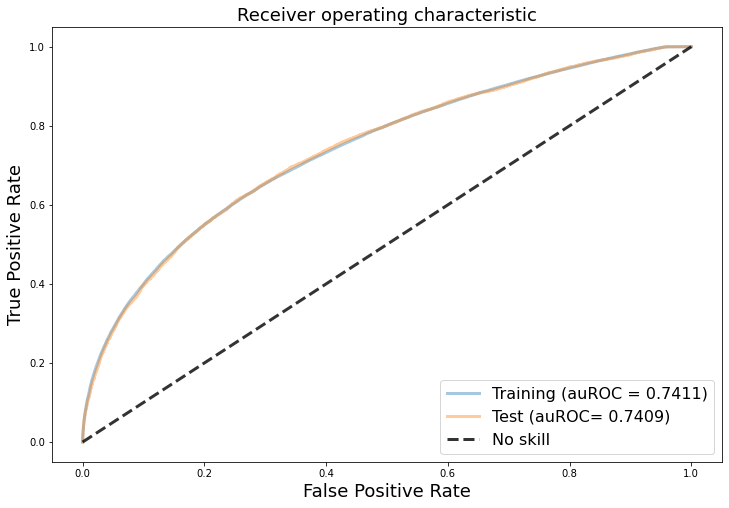

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(fprs_tr, tprs_tr, lw=3, alpha=0.4, label='Training (auROC = %0.4f)' % (roc_auc_tr))
ax.plot(fprs, tprs, lw=3, alpha=0.4, label='Test (auROC= %0.4f)' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

# Scratch

## **Train/test split**

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
split = 0.9

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split, random_state=13, shuffle=True)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272642, 66, 4), (30294, 66, 4), (272642,), (30294,))

In [13]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

In [14]:
test = False
if test:
    num_train = int(len(X_train)/1000)
    num_test = int(len(X_test)/1000)
    X_train, X_test, y_train, y_test = X_train[:num_train, :], X_test[:num_test, :], y_train[:num_train], y_test[:num_test]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272642, 66, 4), (30294, 66, 4), (272642,), (30294,))

## Model

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class EUGENE(nn.Module):
    def __init__(self):
        super(EUGENE, self).__init__()
        self.Conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=16)
        self.Conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5)
        self.Batchnorm = nn.BatchNorm1d(32)
        self.Maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.Drop1 = nn.Dropout(p=0.5)
        self.Linear1 = nn.Linear(1472, 1)

        
    def forward(self, input):
        x = self.Conv1(input)
        x = self.Batchnorm(x)
        x = F.relu(x)
        x = self.Conv2(x)
        x = self.Batchnorm(x)
        x = F.relu(x)
        x = self.Maxpool(x)
        x = x.flatten(1)
        x = self.Drop1(x)
        x = self.Linear1(x)
        return x

## Old dataload

In [ ]:
X = np.load('../data/2021_OLS_Library/ohe_seq/X_ohe-seq_0.18-0.4.npy')
y = np.loadtxt('../data/2021_OLS_Library/y_binary_0.18-0.4.txt', delimiter=' ', dtype=int)

In [ ]:
X.shape, y.shape